# Dynamics Programming Introduction

@[Chaoming Wang](https://github.com/chaoming0625)
@[Xiaoyu Chen](mailto:c-xy17@tsinghua.org.cn)

> What I cannot create, I do not understand.   --- Richard Feynman

The brain is a complex dynamical system. To simulate the dynamics of the brain, one of the most important things is to model the dynamically changed states of each component. Mathematically, the dynamics of a system can be expressed as

$$
\dot{X} = f(X, t)
$$

where $X$ is the state of the system, $t$ is the time, and $f$ is a function describes the time dependence of the system state. 

Simulation of such dynamical systems is called **dynamic modeling**. BrainPy provides users with various tools and convenient interface for neurodynamic modeling, including **dynamic building**, **dynamic simulation**, **dynamic analysis** and **dynamic training**. This section helps users to get familiar with the basic structure and common operations of neurodynamic modeling in BrainPy.

In [4]:
import brainpy as bp
import brainpy.math as bm

bp.math.set_platform('cpu')

##  Dynamical System Building

In BrainPy, [``brainpy.DynamicalSystem``](../apis/auto/building/generated/brainpy.building.brainobjects.DynamicalSystem.rst) is used to define dynamic brain objects. Various children classes are implemented to build different elements, such as [brainpy.NeuGroup](../apis/auto/building/generated/brainpy.building.brainobjects.NeuGroup.rst) for neuron group modeling, [brainpy.TwoEndConn](../apis/auto/building/generated/brainpy.building.brainobjects.TwoEndConn.rst) for synaptic computation, [brainpy.Network](../apis/auto/building/generated/brainpy.building.brainobjects.Network.rst) for network modeling, etc. Arbitrary composition of these objects is also an instance of ``brainpy.DynamicalSystem``. Therefore, ``brainpy.DynamicalSystem`` is the universal language to define dynamical models in BrainPy. 

According to the definition of a dynamical system, any subclass of ``brainpy.DynamicalSystem`` must implement the updating rule in the *update* function (``def update(self, _t, _dt)``), and dynamically changed variables should be defined in the system.

In [5]:
class YourDynamicalSystem(bp.DynamicalSystem):
    
    def __init__(self):
        # define dynamically changed variables
        pass
    
    def update(self, _t, _dt):
        # update the variables
        pass

Here, we illustrate how to build a dynamcial system by using the well known [FitzHugh–Nagumo neuron model](https://brainmodels.readthedocs.io/en/latest/apis/generated/brainmodels.neurons.FHN.html), whose dynamics is given by: 

$$
{\dot {v}}=v-{\frac {v^{3}}{3}}-w+I, \\
\tau {\dot {w}}=v+a-bw.
$$

This model contains two differential equations. In BrainPy, the numerical integration of ordinary differential equations can be accomplished with [brainpy.odeint](../apis/integrators/generated/brainpy.integrators.odeint.rst) (please see [Numerical Integrator](../tutorial_intg/index.rst) for more details). 

The above two differential equations as Python functions can be defined as:

In [6]:
def dV(V, t, w, Iext=0.): 
    return V - V * V * V / 3 - w + Iext
    
def dw(w, t, V, a=0.7, b=0.8): 
    return (V + a - b * w) / self.tau

where ``t`` is the time variable, **arguments before ``t`` are variables, and arguments after ``t`` are parameters**.

Thereafter, the numerical solvers for the two equations can be defined as:

In [7]:
int_V = bp.odeint(dV, method='euler')

int_w = bp.odeint(dw, method='euler')

where the ``method`` defines the numerical integration method to use (all implemented methods can be referred to in [Numerical Solvers for ODEs](../tutorial_intg/ode_numerical_solvers.ipynb)). 

The FitzHugh–Nagumo neuron model can be defined as a Python class, in which the parameters, variables, and integral functions are defined in the constructor ``__init__()``, and the updating rule from the current time $\mathrm{\_t}$ to the next time $\mathrm{\_t + \_dt}$ can be defined in the update function ``update()``.

In [8]:
class FitzHughNagumoModel(bp.DynamicalSystem):
  def __init__(self, num, method='exp_auto'):
    super(FitzHughNagumoModel, self).__init__()

    # parameters
    self.a = 0.7
    self.b = 0.8
    self.tau = 12.5

    # variables
    self.V = bm.Variable(bm.zeros(num))
    self.w = bm.Variable(bm.zeros(num))
    self.Iext = bm.Variable(bm.zeros(num))  # to receive the external input

    # functions
    def dV(V, t, w, Iext=0.): 
        return V - V * V * V / 3 - w + Iext
    def dw(w, t, V, a=0.7, b=0.8): 
        return (V + a - b * w) / self.tau
    self.int_V = bp.odeint(dV, method=method)
    self.int_w = bp.odeint(dw, method=method)

  def update(self, _t, _dt):
    self.V.value = self.int_V(self.V, _t, self.w, self.Iext, _dt)
    self.w.value = self.int_w(self.w, _t, self.V, self.a, self.b, _dt)
    self.Iext[:] = 0.

In [9]:
# instantiation
fhn = FitzHughNagumoModel(2)

In BrainPy, any dynamical model can be defined as a Python class. More advanced usage of dynamical system building can be obtained  in [Dynamics Building](../tutorial_building/index.rst).

##  Dynamical System Simulation

Dynamics simulation in BrainPy is highly efficient. It can deploy models to CPUs or GPUs. To switch the backend device, you can use ``brainpy.math.set_platform("cpu" or "gpu")`` at the top of your script. 

Runners are used for dynamic simulation. They can [**monitor**](../tutorial_simulation/monitors_and_inputs.ipynb) variable trajectories and give [**inputs**](../tutorial_simulation/monitors_and_inputs.ipynb) to target variables during simulation. Currently, BrainPy provides several [runners](../apis/auto/simulation/runner.rst) to satisfy different simulation requirements. Here, we use ``brainpy.StructRunner`` to run the above instance ``fhn``. During simulation, we monitor variables ``V`` and ``w``, and give inputs to ``Iext`` variable. 

In [10]:
runner = bp.StructRunner(fhn, monitors=['V', 'w'], inputs=['Iext', 1.])

# run 100 time units
runner.run(100.)

  0%|          | 0/1000 [00:00<?, ?it/s]

0.19694924354553223

The monitored values of variables over time are recorded in ``runner.mon`` and can be visualized through [brainpy.visualize](../apis/auto/visualization.rst).

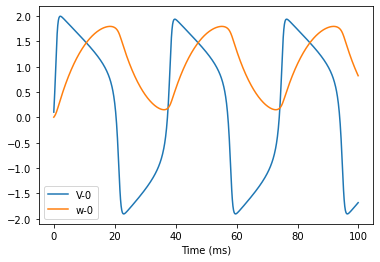

In [11]:
bp.visualize.line_plot(runner.mon.ts, runner.mon['V'], legend='V')
bp.visualize.line_plot(runner.mon.ts, runner.mon['w'], legend='w', show=True)

For more details, please refer to the tutorials in [Dynamics Simulation](../tutorial_simulation/index.rst).

##  Dynamical System Analysis

In BrainPy, the defined model can not only be used for simulation, but also to perform automatic dynamics analysis. 

BrainPy provides rich interfaces to support analysis, incluing

- phase plane analysis, bifurcation analysis, and fast-slow bifurcation analysis for [low-dimensional systems](../tutorial_analysis/lowdim_analysis.ipynb);
- linearization analysis and fixed/slow point finding for [high-dimensional systems](../tutorial_analysis/highdim_analysis.ipynb). 

For the above FitzHugh-Nagumo model, it is a two variable model. We can use [brainpy.analysis.PhasePlane2D](../apis/auto/analysis/generated/brainpy.analysis.lowdim.PhasePlane2D.rst) to make phase plane analysis. 

In [16]:
bp.math.enable_x64()

I am computing fx-nullcline ...
I am evaluating fx-nullcline by optimization ...
I am computing fy-nullcline ...
I am evaluating fy-nullcline by optimization ...
I am creating the vector field ...
I am searching fixed points ...
I am trying to find fixed points by optimization ...
	There are 866 candidates
I am trying to filter out duplicate fixed points ...
	Found 1 fixed points.
	#1 V=-0.2738719079019268, w=0.5329731347793121 is a unstable node.
I am plotting the trajectory ...


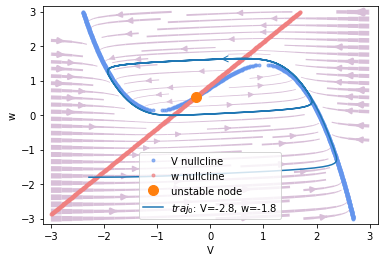

In [20]:
analyzer = bp.analysis.PhasePlane2D(
  fhn,
  target_vars={'V': [-3, 3], 'w': [-3., 3.]},
  pars_update={'Iext': 0.8}, 
  resolutions=0.01,
)
analyzer.plot_nullcline()
analyzer.plot_vector_field()
analyzer.plot_fixed_point()
analyzer.plot_trajectory({'V': [-2.8], 'w': [-1.8]}, duration=100.)
analyzer.show_figure()

To find more tools for dynamics analysis, you can refer to the tutorials in [Dynamics Analysis](../tutorial_analysis/index.rst) and examples in [BrainPy-Examples](https://brainpy-examples.readthedocs.io/en/brainpy-2.x/dynamics_analysis/index.html).

##  Dynamical System Training

In recent years, we saw the revolution that training a dynamical system from data or tasks has provided important insights to understand brain functions. To support this, BrainPy porvides various interfaces to help users train dynamical systems. 

Examples of using FORCE learning algorithm, back-propagation algorithm or others to train recurrent neural networks can be found in [BrainPy-Examples](https://brainpy-examples.readthedocs.io/en/brainpy-2.x/recurrent_networks/index.html). 